# one must install pygmt using the instructions linked below https://www.pygmt.org/v0.3.0/install.html#installing-gmt-and-other-dependencies

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pygmt
import os
import pandas as pd

# get the global MSS grids the first time only

In [2]:
#!wget -q --no-check-certificate https://topex.ucsd.edu/pub/MSS_replace/CNES_CLS_22_H_WGS84.nc
#!wget -q --no-check-certificate https://topex.ucsd.edu/pub/MSS_replace/mss_sio_32.1_WGS84.nc

# open the two mss grid and display an area

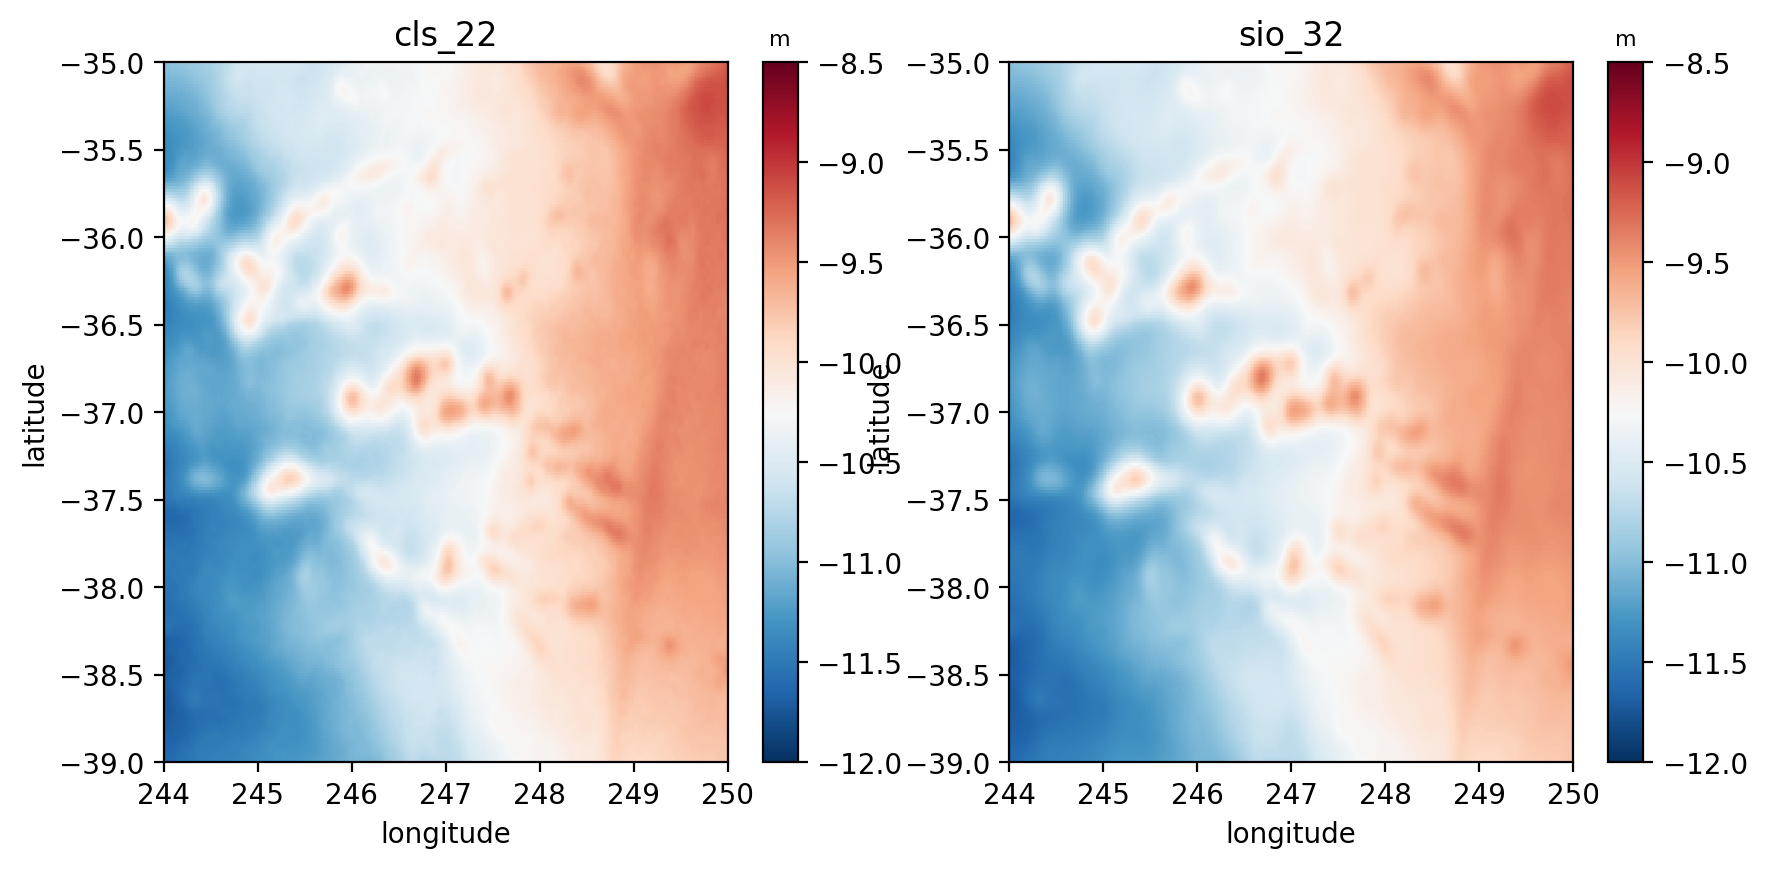

In [3]:
grid_file32 = xr.open_dataset("mss_sio_32.1_WGS84.nc")
cgrid32 = grid_file32.sel(lon=slice(244,250), lat=slice(-39,-35))
grid_file22 = xr.open_dataset("CNES_CLS_22_H_WGS84.nc")
cgrid22 = grid_file22.sel(lon=slice(244,250), lat=slice(-39,-35))
plt.figure(figsize=(10, 10), dpi=200)
plt.subplot(222); plt.pcolormesh(cgrid32.lon, cgrid32.lat, cgrid32.z, cmap='RdBu_r', shading='auto', vmin = -12, vmax = -8.5)
plt.xlim([244,250]); plt.ylim([-39,-35]); plt.title('sio_32'); plt.xlabel('longitude'); plt.ylabel('latitude')
clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8); 
plt.subplot(221); plt.pcolormesh(cgrid22.lon, cgrid22.lat, cgrid22.z, cmap='RdBu_r', shading='auto', vmin = -12, vmax = -8.5)
plt.xlim([244,250]); plt.ylim([-39,-35]); plt.title('cls_22'); plt.xlabel('longitude'); plt.ylabel('latitude')
clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8); 
plt.show()

# read a netcdf file of L3 expert

In [4]:
ds_Foundation = xr.open_dataset("SWOT_L3_LR_SSH_Expert_547_011_20230609T190905_20230609T200010_v0.1.nc") 
num_lines = ds_Foundation.sizes['num_lines']
num_pixels = ds_Foundation.sizes['num_pixels']
num_lines

9860

# extract the sio_32 MSS at the locations of the SWOT data using grdtrack

In [5]:
grid32 = "mss_sio_32.1_WGS84.nc"
data32 = {'longitude': ds_Foundation["longitude"].values.flatten(),
        'latitude': ds_Foundation["latitude"].values.flatten()}
track_points = pd.DataFrame(data32)
# Use grdtrack to sample the grid along the track
track_data32 = pygmt.grdtrack(points=track_points, grid=grid32,newcolname="sio32")

# extract the cls_22 MSS at the locations of the SWOT data using grdtrack

In [6]:
grid22 = "CNES_CLS_22_H_WGS84.nc"
data22 = {'longitude': ds_Foundation["longitude"].values.flatten(),
        'latitude': ds_Foundation["latitude"].values.flatten()}
track_points = pd.DataFrame(data22)
# Use grdtrack to sample the grid along the track
track_data22 = pygmt.grdtrack(points=track_points, grid=grid22,newcolname="cls22")


# take the three-way differences of the models

In [7]:
cls22_mss_hy = track_data22.cls22.to_numpy().reshape(num_lines, num_pixels) - ds_Foundation.mss
sio32_mss_hy = track_data32.sio32.to_numpy().reshape(num_lines, num_pixels) - ds_Foundation.mss
cls22_sio32 = track_data22.cls22.to_numpy().reshape(num_lines, num_pixels) - track_data32.sio32.to_numpy().reshape(num_lines, num_pixels) 

# plot the three models and their differences

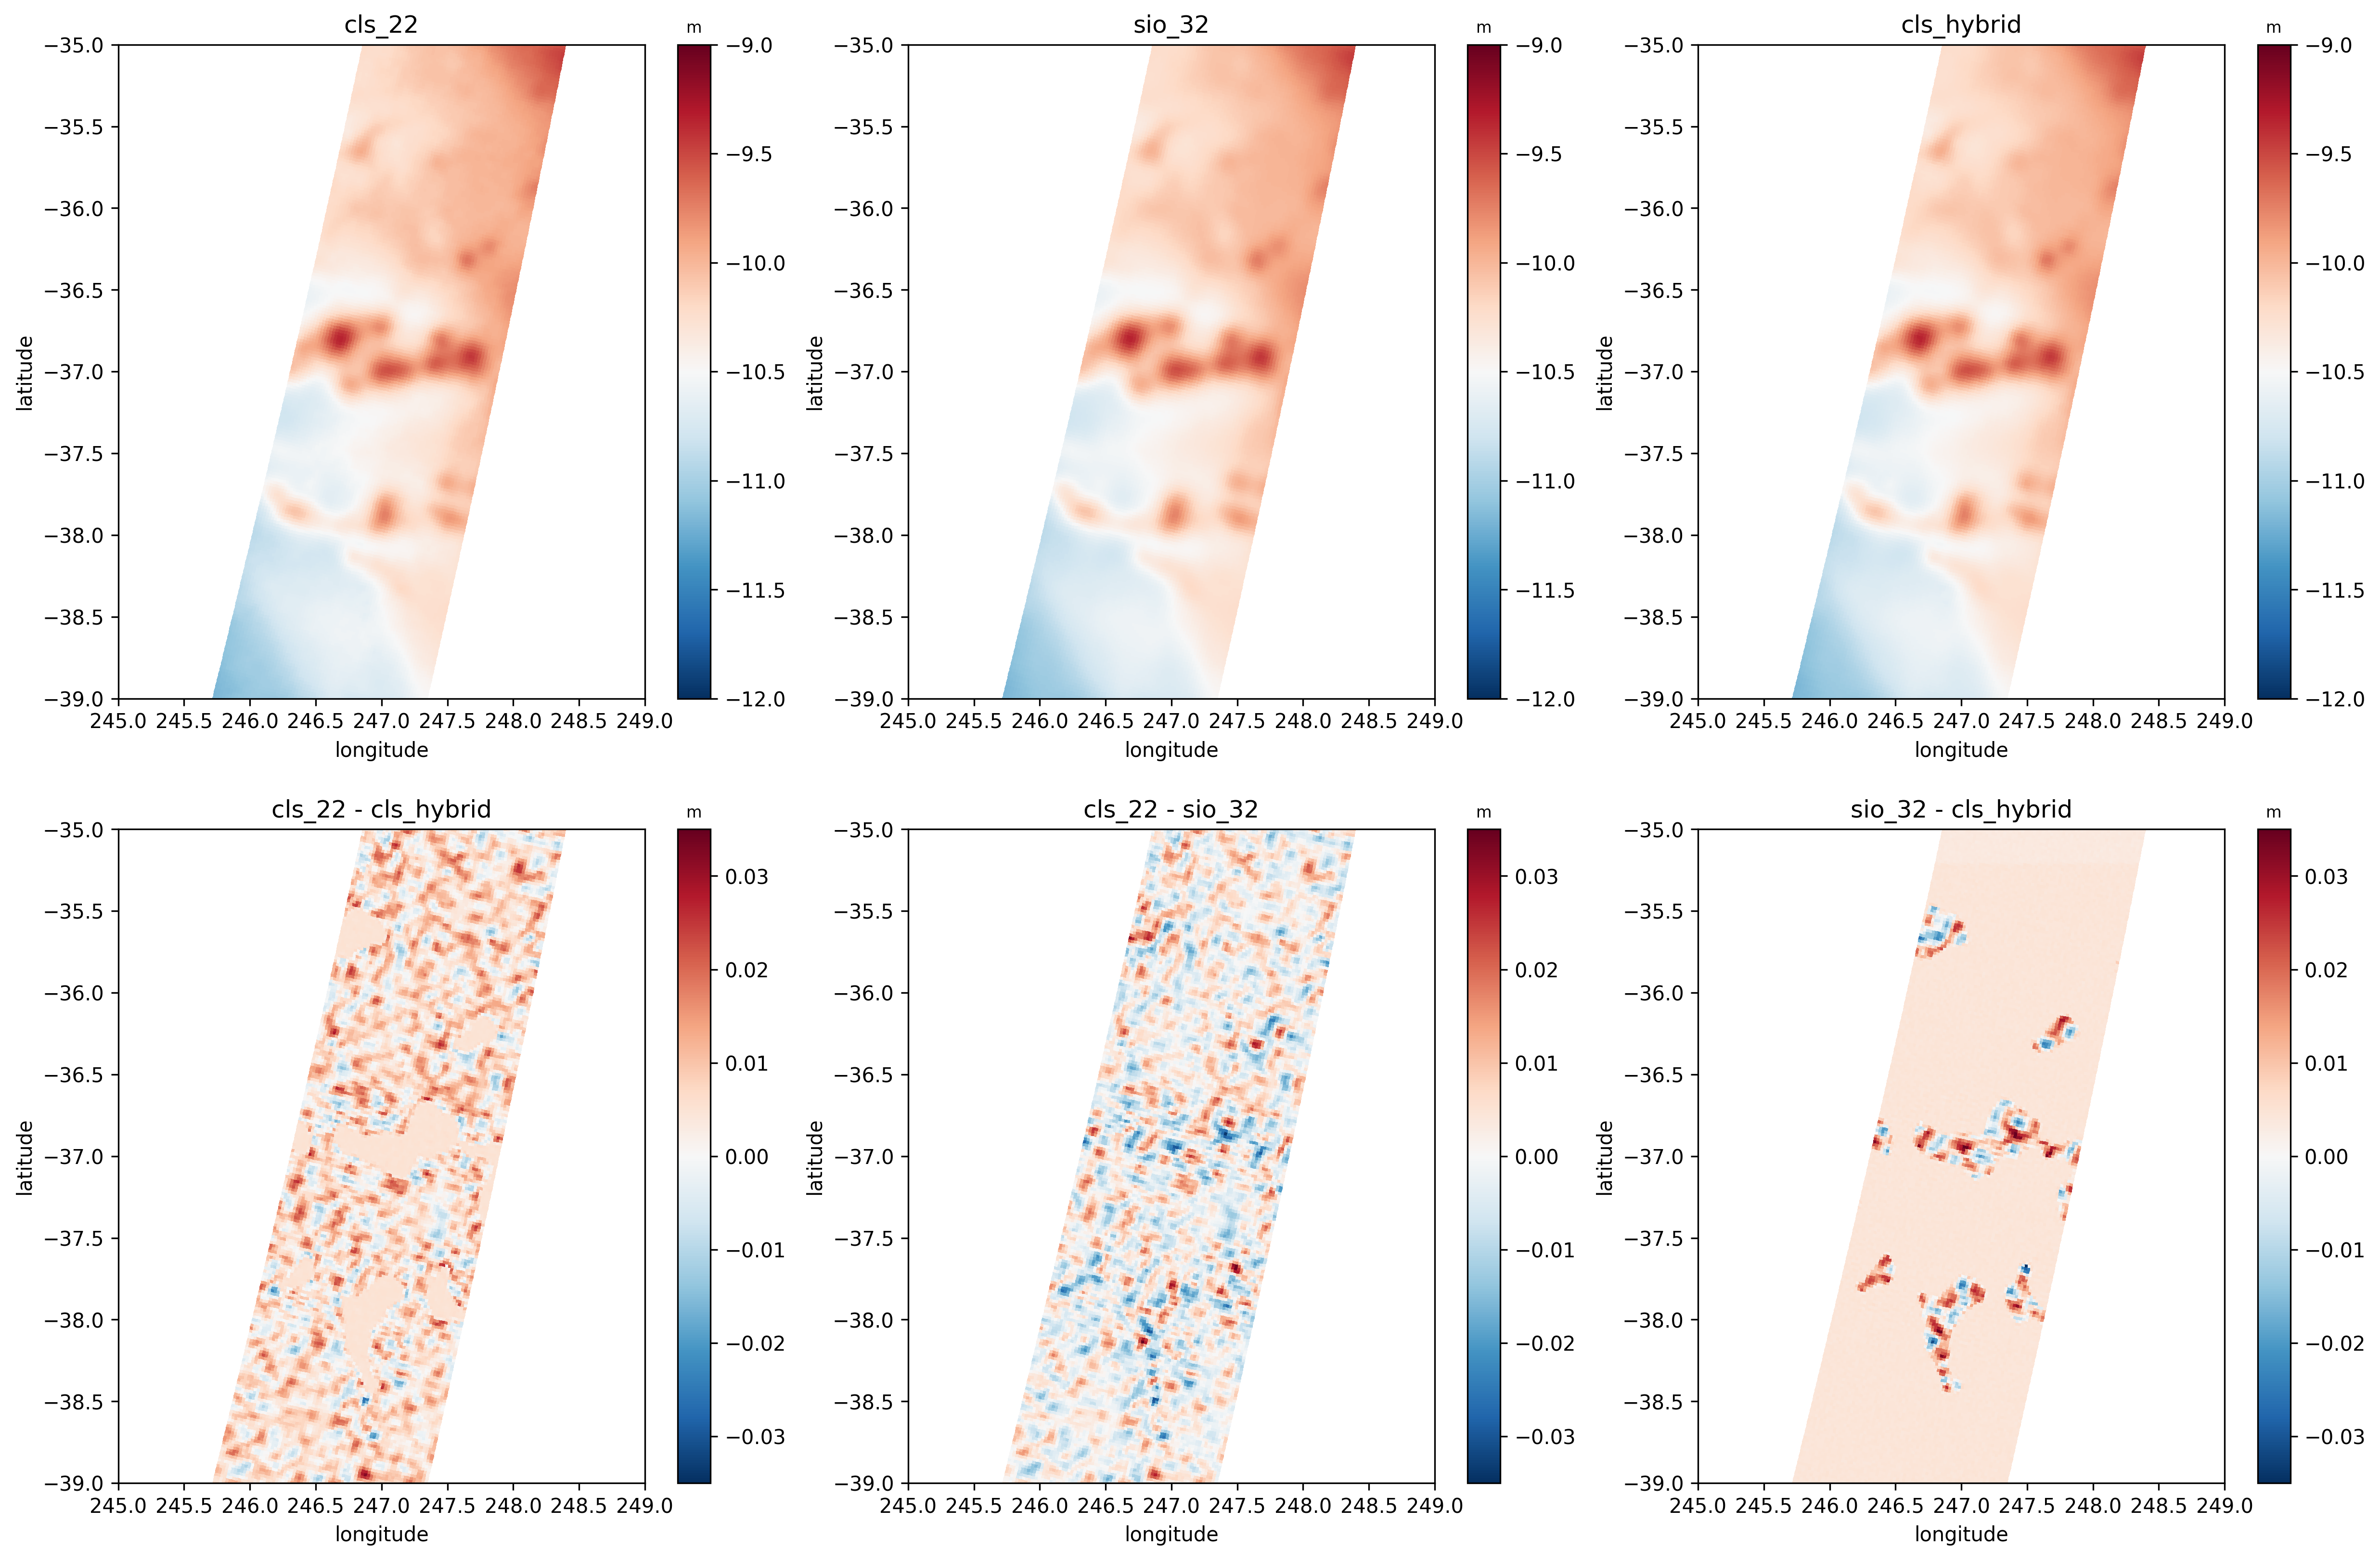

In [8]:
plt.figure(figsize=(20,20), dpi=300)

plt.subplot(331)
plt.pcolormesh(track_data22.longitude.to_numpy().reshape(num_lines, num_pixels), track_data22.latitude.to_numpy().reshape(num_lines, num_pixels), track_data22.cls22.to_numpy().reshape(num_lines, num_pixels), cmap='RdBu_r', vmin=-12, vmax=-9, shading='auto')
plt.xlim([245,249]); plt.ylim([-39,-35]); plt.xlabel('longitude'); plt.ylabel('latitude'); clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8)
plt.title('cls_22')

plt.subplot(332)
plt.pcolormesh(track_data32.longitude.to_numpy().reshape(num_lines, num_pixels), track_data32.latitude.to_numpy().reshape(num_lines, num_pixels), track_data32.sio32.to_numpy().reshape(num_lines, num_pixels), cmap='RdBu_r', vmin=-12, vmax=-9, shading='auto')
plt.xlim([245,249]); plt.ylim([-39,-35]); plt.xlabel('longitude'); plt.ylabel('latitude'); clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8)
plt.title('sio_32')

plt.subplot(333)
plt.pcolormesh(ds_Foundation.longitude, ds_Foundation.latitude, ds_Foundation.mss, cmap='RdBu_r', vmin=-12, vmax=-9, shading='auto')
plt.xlim([245,249]); plt.ylim([-39,-35]); plt.xlabel('longitude'); plt.ylabel('latitude'); clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8)
plt.title('cls_hybrid')

plt.subplot(334)
plt.pcolormesh(ds_Foundation.longitude, ds_Foundation.latitude, cls22_mss_hy, cmap='RdBu_r', shading='auto',vmin = -.035, vmax = .035)
plt.xlim([245,249]); plt.ylim([-39,-35]); plt.xlabel('longitude'); plt.ylabel('latitude'); clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8)
plt.title('cls_22 - cls_hybrid')

plt.subplot(335)
plt.pcolormesh(ds_Foundation.longitude, ds_Foundation.latitude, cls22_sio32, cmap='RdBu_r', shading='auto',vmin = -.035, vmax = .035)
plt.xlim([245,249]); plt.ylim([-39,-35]); plt.xlabel('longitude'); plt.ylabel('latitude'); clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8)
plt.title('cls_22 - sio_32')

plt.subplot(336)
plt.pcolormesh(ds_Foundation.longitude, ds_Foundation.latitude, sio32_mss_hy, cmap='RdBu_r', shading='auto', vmin = -.035, vmax = .035)
plt.xlim([245,249]); plt.ylim([-39,-35]); plt.xlabel('longitude'); plt.ylabel('latitude'); clb = plt.colorbar(); clb.ax.set_title('m',fontsize=8)
plt.title('sio_32 - cls_hybrid')


plt.show()